In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import PreprocessSMILES, SimpleRegressions, SmallNN, LstmRegressor, DataLoader, Training

from utils import load_config, seed_everything

import gensim

print(gensim.__version__) # 3.7.1

2024-04-22 00:22:06.294754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 00:22:07.274313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-22 00:22:07.274479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-22 00:22:07.274490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

3.7.1


## Майнинг данных из SMILES и объединение молекул в смеси

In [4]:

from pandas.core.frame import DataFrame


descriptors: DataFrame = pd.read_csv(filepath_or_buffer='./materials/descriptors.csv')
descriptors_test: DataFrame = pd.read_csv(filepath_or_buffer='./materials/descriptors_test.csv')

common_columns = list(set(descriptors.columns) & set(descriptors_test.columns))

filtered_descriptors = descriptors[common_columns]
filtered_descriptors_test = descriptors_test[common_columns]

filtered_descriptors.to_csv(path_or_buf='./materials/descriptors.csv', index=False)
filtered_descriptors_test.to_csv(path_or_buf='./materials/descriptors_test.csv', index=False)

In [5]:
############################################################################################################################################
################################################# TRAIN ####################################################################################
directory = './materials/'
preprocessor = PreprocessSMILES(directory, 'canonical_smiles')
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv", "descriptors.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf, "train")
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df.reset_index(drop=True, inplace=True)
mdf['graphs'] = preprocessor.generate_graphs(mdf)
mdf.drop(columns=['oil_property_param_value', 'mol'], inplace=True)
joined_df.head(3)
# X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.bias', 'regression.dense.bias', 'regression.out_proj.weight', 'norm_mean', 'norm_std']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,canonical_smiles,smiles,descriptors_array,oil_property_param_value,similarity_vectors,embeddings
0,007b4d7a-b1f8-11ed-93b4-005056921581,"[2246728737, 3537119515, 2245273601, 242354360...","[-3.4431674, -0.62736166, -2.157891, -0.715889...","CCCCCC(C)C, CCCC(C)CCC, CCCCC","CC(C)CCCCC, CCCC(C)CCC, CCCCC","[0.0, 261.36, 0.0, 0.0, 1678.522199270234, 0.0...",13360.0,"[0.3888888888888889, 0.4, 0.2857142857142857]","[0.002832591300830245, -0.15190550684928894, 0..."
1,0109d480-f91d-11ec-96ac-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-5.5208826, 0.3777768, -3.6566508, -1.7744193...","CCCCC(C)CC, CCCC(C)CCC, CCCCC, CCCCC(C)C, CCCC...","CCC(C)CCCC, CCCC(C)CCC, CCCCC, CCCCC(C)C, O=C(...","[0.0, 435.6, 0.0, 0.0, 2797.5369987837234, 0.0...",111400.0,"[0.4444444444444444, 0.375, 0.5555555555555556...","[-0.005525789689272642, -0.05767503380775452, ..."
2,01bc9ed0-0f2f-11ed-9900-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-2.5844321, 0.054932743, -2.082138, -0.734171...","CCC(CC)C(=O)OC, CCCC(C)CCC, CCCCC","CCC(C(OC)=O)CC, CCCC(C)CCC, CCCCC","[0.0, 261.36, 0.0, 0.0, 1678.522199270234, 0.0...",16325.0,"[0.16666666666666666, 0.14285714285714285, 0.2...","[0.06517738103866577, -0.07108601182699203, -0..."


In [6]:
##################################################################################################################
############################################### TEST ################################################################
preprocessor_test = PreprocessSMILES(directory=directory, base_on='canonical_smiles', task = 'test')
mdf_test = preprocessor_test.preprocess_data("test_data_fix_concat.csv", "descriptors_test.csv")
grouped_mdf_test = preprocessor_test.preprocess_mol2vec(mdf_test)
smiles_df_test = preprocessor_test.smiles2sentence(mdf_test)
joined_df_test = pd.merge(grouped_mdf_test, smiles_df_test, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df_test = preprocessor_test.embed_smiles(joined_df_test, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df_test.reset_index(drop=True, inplace=True)
mdf_test['graphs'] = preprocessor_test.generate_graphs(mdf_test)
mdf_test.drop(columns=['mol'], inplace=True)
joined_df_test.head(3)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.bias', 'regression.dense.bias', 'regression.out_proj.weight', 'norm_mean', 'norm_std']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,canonical_smiles,smiles,descriptors_array,similarity_vectors,embeddings
0,0189e1f2-2ab8-11ee-8be1-005056921581,"[2246728737, 3542456614, 2245384272, 117312591...","[-2.5093365, -0.48656785, -1.1924767, -0.49072...","CCCC(C)CCC, CCCCCCC","CCCC(C)CCC, CCCCCCC","[0.0, 87.12000000000002, 0.0, 0.0, 559.5073997...",[0.26666666666666666],"[-0.06721530854701996, -0.005647439043968916, ..."
1,02114c6e-eb16-11ed-9974-005056921581,"[2246728737, 3537119515, 2245273601, 84546060,...","[-6.4228168, -1.2596623, -4.4797096, -2.153883...","CCCCOC(=O)C(C)C(=O)OCCCC, CCCCCCCC(C)C(CCCCCC)...","CC(C(OCCCC)=O)C(OCCCC)=O, CCCCCCC(C(C)CCCCCCC)...","[0.0, 87.12000000000002, 0.0, 0.0, 559.5073997...",[0.22857142857142856],"[-0.014106023125350475, 0.0029005289543420076,..."
2,03ac1c22-6af9-11ed-8d22-005056921581,"[2246728737, 3537123720, 2245277810, 170459982...","[-11.42185, -0.05583578, -8.702778, 0.75527394...","COC(=O)C(C)(C)C, CCCCCC(C)C, CCCC(CC(C)(CC)C(=...","CC(C)(C)C(OC)=O, CC(C)CCCCC, CCC(C(OC)=O)(CC(C...","[0.0, 217.80000000000004, 0.0, 0.0, 1398.76849...","[0.037037037037037035, 0.2894736842105263, 0.0...","[0.07875557243824005, 0.03385624662041664, 0.2..."


In [7]:
print(len(joined_df_test['descriptors_array'][100]))
print(len(joined_df['descriptors_array'][100]))

1097
1097


In [8]:
# TODO: пример графа, на данный момент не используется

mdf['graphs'][0]

Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

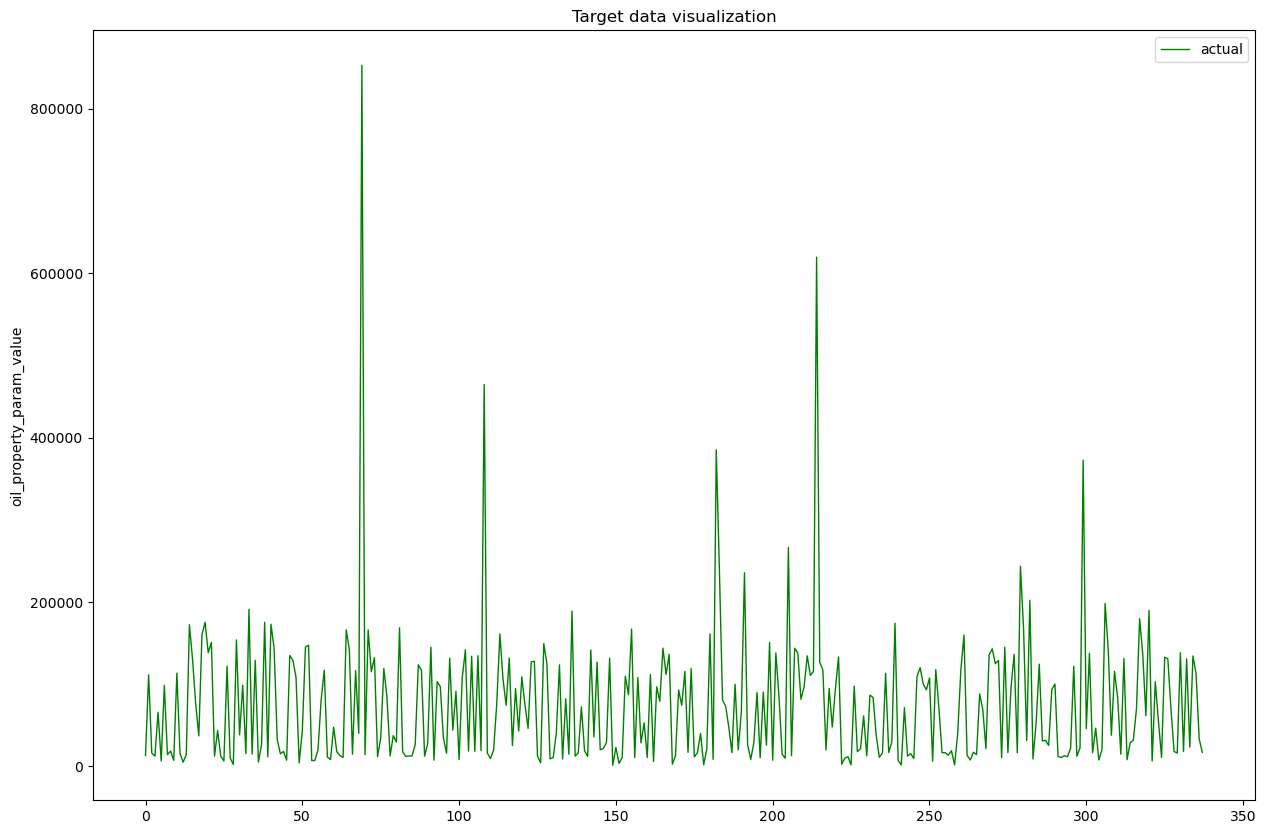

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Target data visualization")
plt.show()


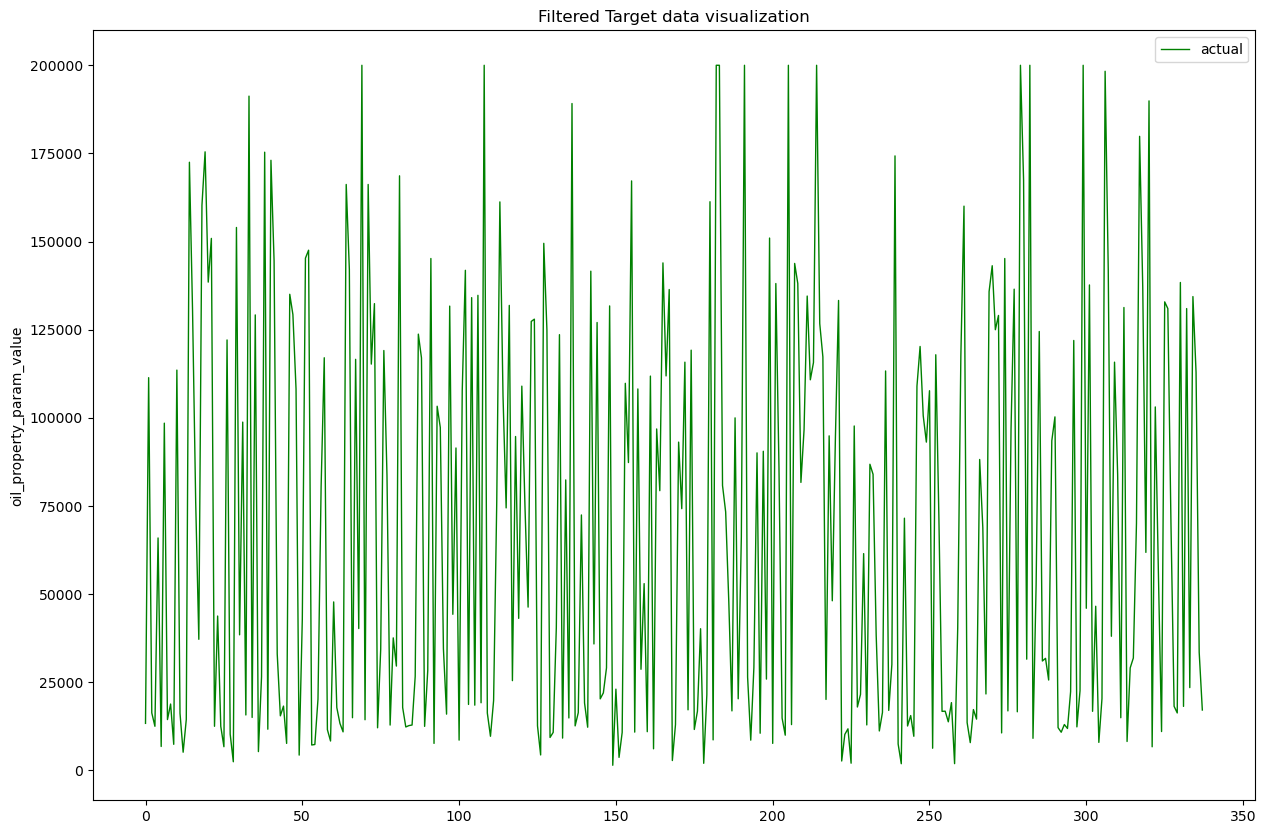

In [10]:
## Обработка выбросов для обучения

joined_df['oil_property_param_value'] = joined_df['oil_property_param_value'].apply(lambda x: min(x, 200000))
plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Filtered Target data visualization")
plt.show()

## Подготовка данных для обучения на объединенных последовательностях векторов, эмбедингов смеси и близости расстояний между молекулами.


In [11]:
# как similarity_score используется TanimotoSimilarity из rdkit

static_cols = ['embeddings'] #['mol2vec', 'embeddings', 'descriptors_array']
dynamic_cols = ['similarity_vectors'] #['similarity_vectors']

########################################## TRAIN DATALOADER ######################################################

data_loader = DataLoader(joined_df, static_cols, dynamic_cols)
dataset = data_loader.get_dataset()

########################################## TEST DATALOADER  ######################################################

test_data_loader = DataLoader(joined_df_test, static_cols, dynamic_cols, task = 'test')
test_dataset, _ = test_data_loader.get_dataset()

Shape of data_x: (338, 1, 390)
Shape of data_y: (338, 1)
Shape of data_x: (138, 1, 390)


## Тренировка

In [12]:
# Тренировка 3 архитектур нейросеток

# config = load_config("config.yml", "embeddings", "torchRegressor")
# seed_everything()
# trainer = Training(config, dataset.data_x, y=dataset.data_y, test_X = test_dataset.data_x, cross_validation = False)

# pred1 = trainer.average_prediction()
# pred2 = trainer.weighted_average_prediction(model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

-----Seed Set!-----
lr 0.005


BEST ----> 
GRURegressor Epoch 0, train_loss 1.135, val_loss 1.395, val_mae 61473.4296875
BEST ----> 
GRURegressor Epoch 1, train_loss 0.873, val_loss 0.876, val_mae 47396.296875
BEST ----> 
GRURegressor Epoch 2, train_loss 0.898, val_loss 0.817, val_mae 43021.375
GRURegressor Epoch 3, train_loss 0.762, val_loss 0.844, val_mae 41522.55859375
GRURegressor Epoch 4, train_loss 0.727, val_loss 0.832, val_mae 39521.82421875
GRURegressor Epoch 5, train_loss 0.744, val_loss 0.885, val_mae 43059.34375
BEST ----> 
GRURegressor Epoch 6, train_loss 0.715, val_loss 0.778, val_mae 42319.09375
GRURegressor Epoch 7, train_loss 0.738, val_loss 0.803, val_mae 41224.8828125
GRURegressor Epoch 8, train_loss 0.712, val_loss 0.84, val_mae 41206.61328125
GRURegressor Epoch 9, train_loss 0.728, val_loss 0.778, val_mae 40363.2578125
GRURegressor Epoch 10, train_loss 0.685, val_loss 1.009, val_mae 46729.18359375
GRURegressor Epoch 11, train_loss 0.677, val_loss 0.82, val_mae 41221.44921875
GRURegressor Epoch 1

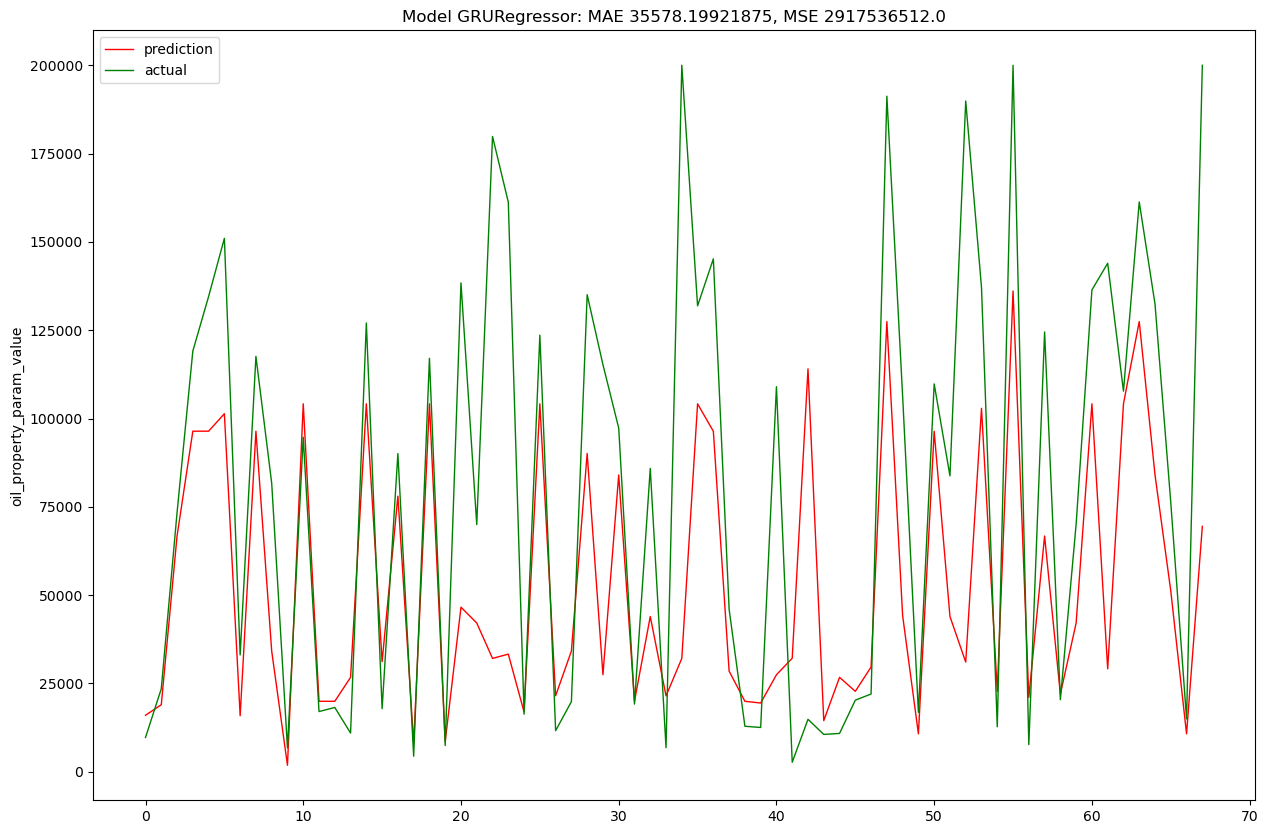

MAE score: 35578.195
MSE score: 2917536500.0


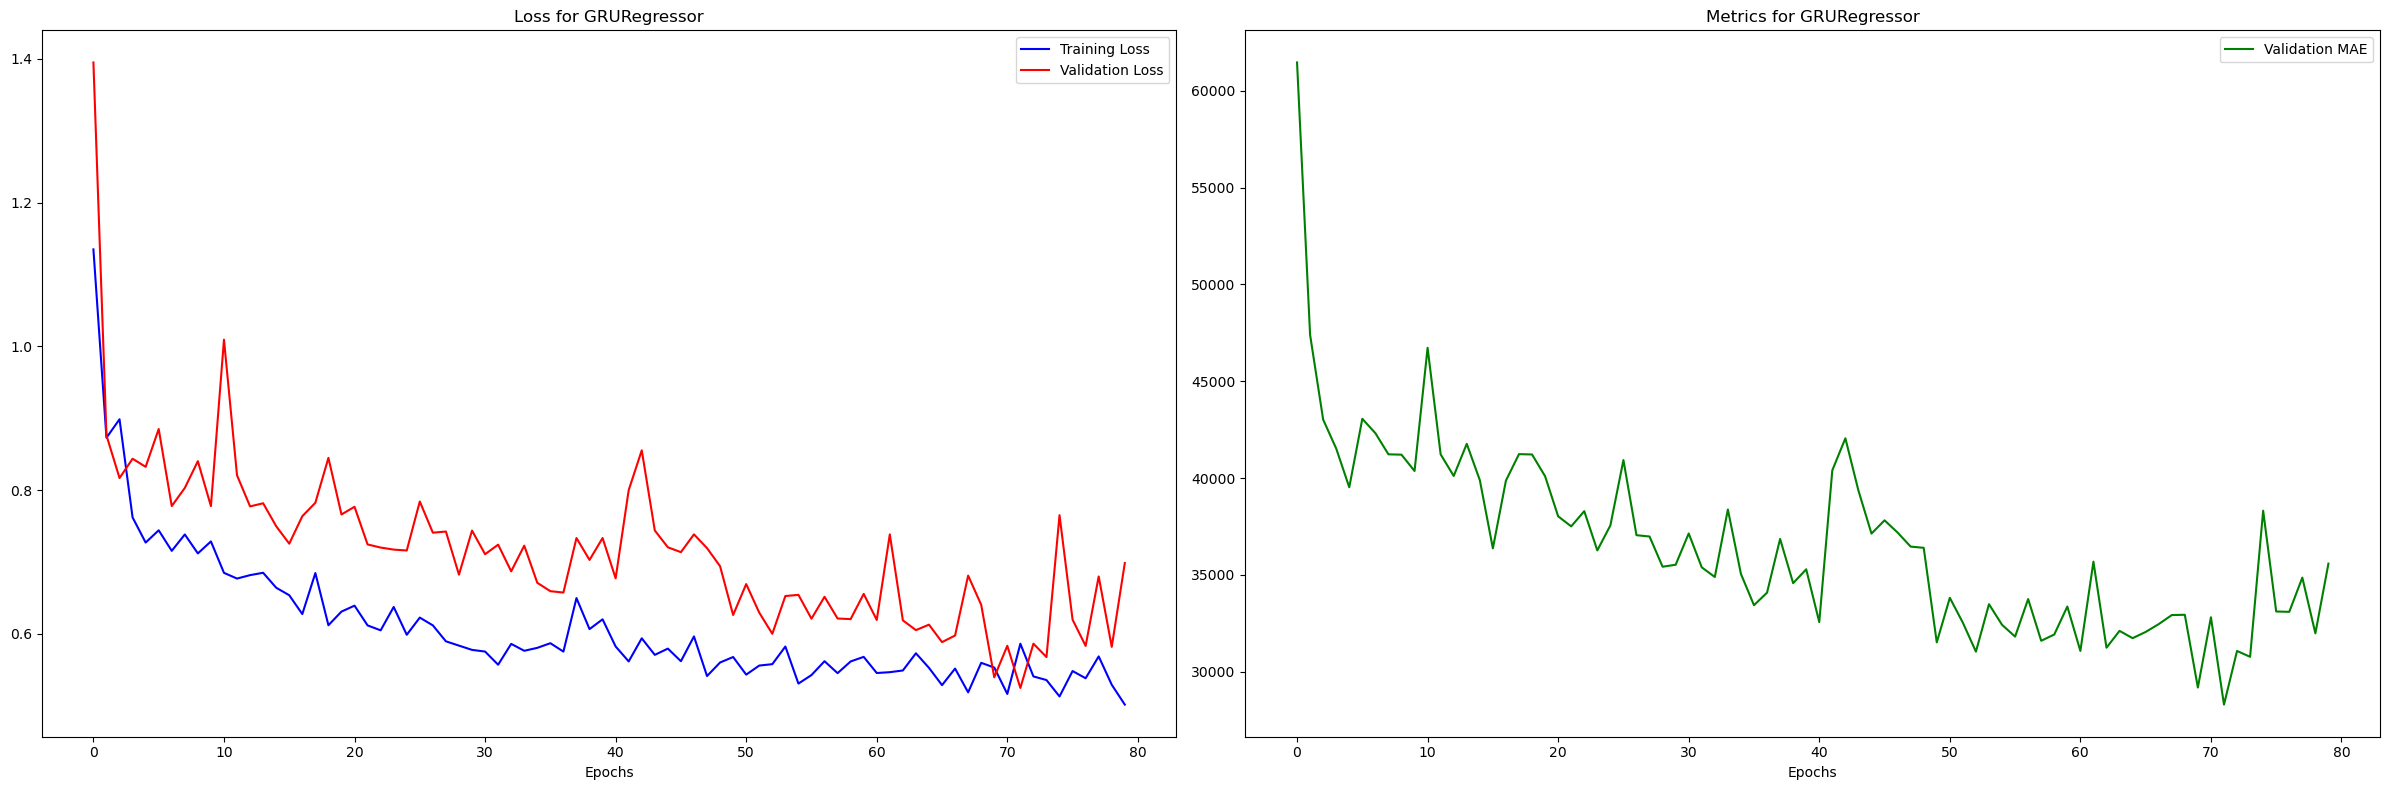

lr 0.02
BEST ----> 
ConvRegressor Epoch 0, train_loss 2.252, val_loss 1.02, val_mae 55868.6796875
ConvRegressor Epoch 1, train_loss 1.81, val_loss 2.513, val_mae 98981.0078125
ConvRegressor Epoch 2, train_loss 1.987, val_loss 1.061, val_mae 57202.65234375
ConvRegressor Epoch 3, train_loss 1.253, val_loss 1.05, val_mae 56371.10546875
ConvRegressor Epoch 4, train_loss 1.345, val_loss 1.058, val_mae 57113.046875
ConvRegressor Epoch 5, train_loss 1.576, val_loss 1.689, val_mae 69286.46875
ConvRegressor Epoch 6, train_loss 1.539, val_loss 1.205, val_mae 60061.4375
ConvRegressor Epoch 7, train_loss 1.112, val_loss 1.095, val_mae 58024.62109375
ConvRegressor Epoch 8, train_loss 1.125, val_loss 1.079, val_mae 57646.328125
ConvRegressor Epoch 9, train_loss 1.525, val_loss 1.048, val_mae 56790.28125
BEST ----> 
ConvRegressor Epoch 10, train_loss 1.224, val_loss 1.015, val_mae 55679.43359375
ConvRegressor Epoch 11, train_loss 0.918, val_loss 1.196, val_mae 59909.71484375
ConvRegressor Epoch 12, t

KeyboardInterrupt: 

In [50]:
config = load_config("config.yml", "embeddings_sim", "torchRegressor")
seed_everything()
trainer = Training(config, dataset.data_x, y=dataset.data_y, test_X = test_dataset.data_x, cross_validation = False)

pred1 = trainer.average_prediction()
pred2 = trainer.weighted_average_prediction(model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

In [ ]:
trainer.trained_models

[GRURegressor(
   (gru): GRU(32, 2, num_layers=2, batch_first=True)
   (linear): Sequential(
     (0): Linear(in_features=26, out_features=1024, bias=True)
     (1): Dropout(p=0.3, inplace=False)
     (2): ReLU()
     (3): Linear(in_features=1024, out_features=512, bias=True)
     (4): Dropout(p=0.3, inplace=False)
     (5): ReLU()
   )
   (head1): Linear(in_features=512, out_features=1, bias=True)
   (loss1): MSELoss()
   (loss3): L1Loss()
 ),
 ConvRegressor(
   (conv_block): Sequential(
     (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,))
     (1): Dropout(p=0.3, inplace=False)
     (2): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
     (3): ReLU()
     (4): Conv1d(8, 16, kernel_size=(5,), stride=(2,))
     (5): Dropout(p=0.3, inplace=False)
     (6): AvgPool1d(kernel_size=(11,), stride=(11,), padding=(0,))
     (7): Conv1d(16, 4, kernel_size=(3,), stride=(3,))
     (8): Flatten(start_dim=1, end_dim=-1)
   )
   (linear): Sequential(
     (0): Linear(in_features=20, out_features=1024,

## Тренировка Бустингов

### Эмбединги

In [ ]:
# config = load_config("config.yml", "embeddings", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Векторное представление + similarity

In [21]:
# config = load_config("config.yml", "mol_similarity", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Дескрипторы

In [22]:
# config = load_config("config.yml", "descriptors", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Эмбеддинги + дескрипторы

In [23]:
# config = load_config("config.yml", "embeddings_descriptors", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Эмбеддинги + similarity

Catboost
0:	learn: 0.9652179	test: 1.0792526	best: 1.0792526 (0)	total: 84.2ms	remaining: 2m 48s
1:	learn: 0.9238836	test: 1.0403351	best: 1.0403351 (1)	total: 103ms	remaining: 1m 42s
2:	learn: 0.8828144	test: 1.0010872	best: 1.0010872 (2)	total: 121ms	remaining: 1m 20s
3:	learn: 0.8481754	test: 0.9714035	best: 0.9714035 (3)	total: 139ms	remaining: 1m 9s
4:	learn: 0.8198266	test: 0.9476719	best: 0.9476719 (4)	total: 156ms	remaining: 1m 2s
5:	learn: 0.7938584	test: 0.9248074	best: 0.9248074 (5)	total: 176ms	remaining: 58.3s
6:	learn: 0.7668360	test: 0.8983319	best: 0.8983319 (6)	total: 193ms	remaining: 54.8s
7:	learn: 0.7428560	test: 0.8836207	best: 0.8836207 (7)	total: 208ms	remaining: 51.9s
8:	learn: 0.7217349	test: 0.8643350	best: 0.8643350 (8)	total: 224ms	remaining: 49.6s
9:	learn: 0.7015171	test: 0.8481294	best: 0.8481294 (9)	total: 240ms	remaining: 47.9s
10:	learn: 0.6877475	test: 0.8368099	best: 0.8368099 (10)	total: 256ms	remaining: 46.2s
11:	learn: 0.6733437	test: 0.8267141	be

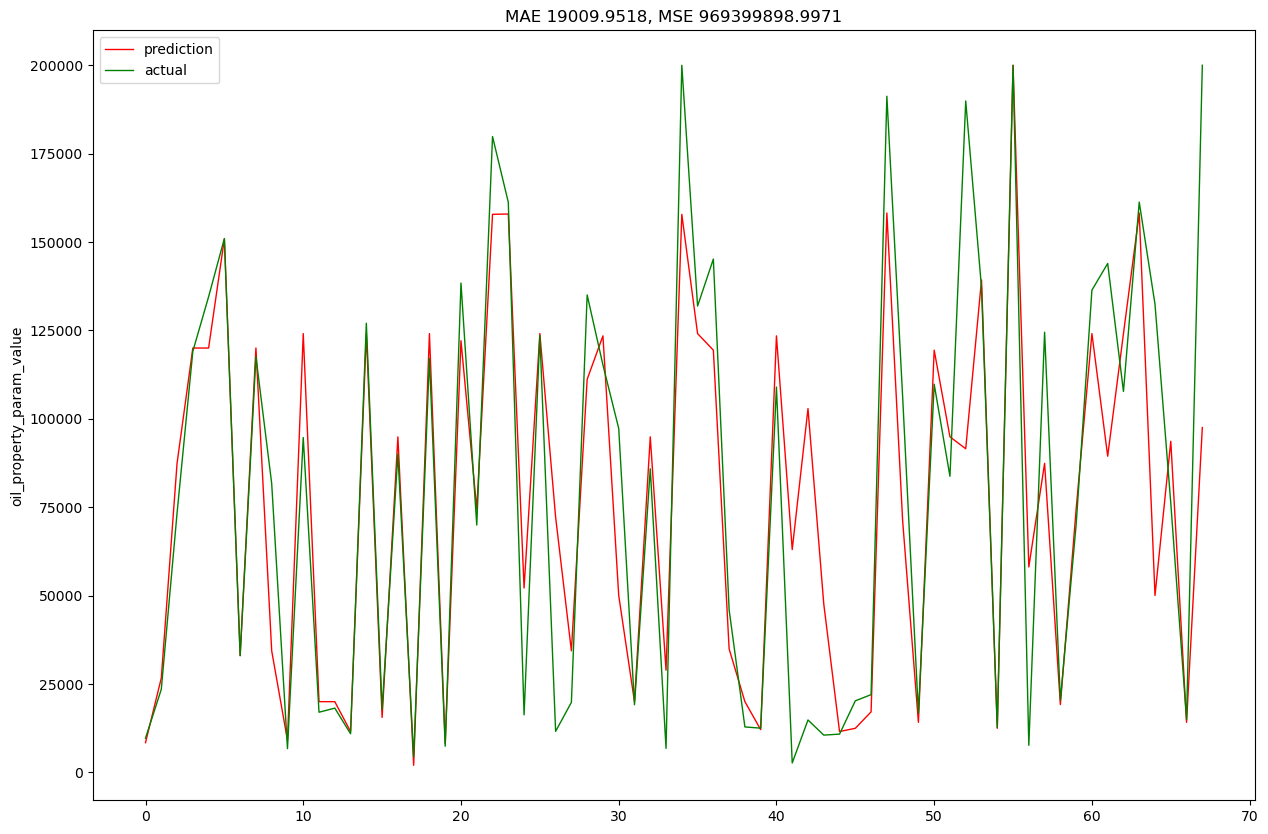

MAE score: 19009.9518
MSE score: 969399898.9971

LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23292
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 390
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

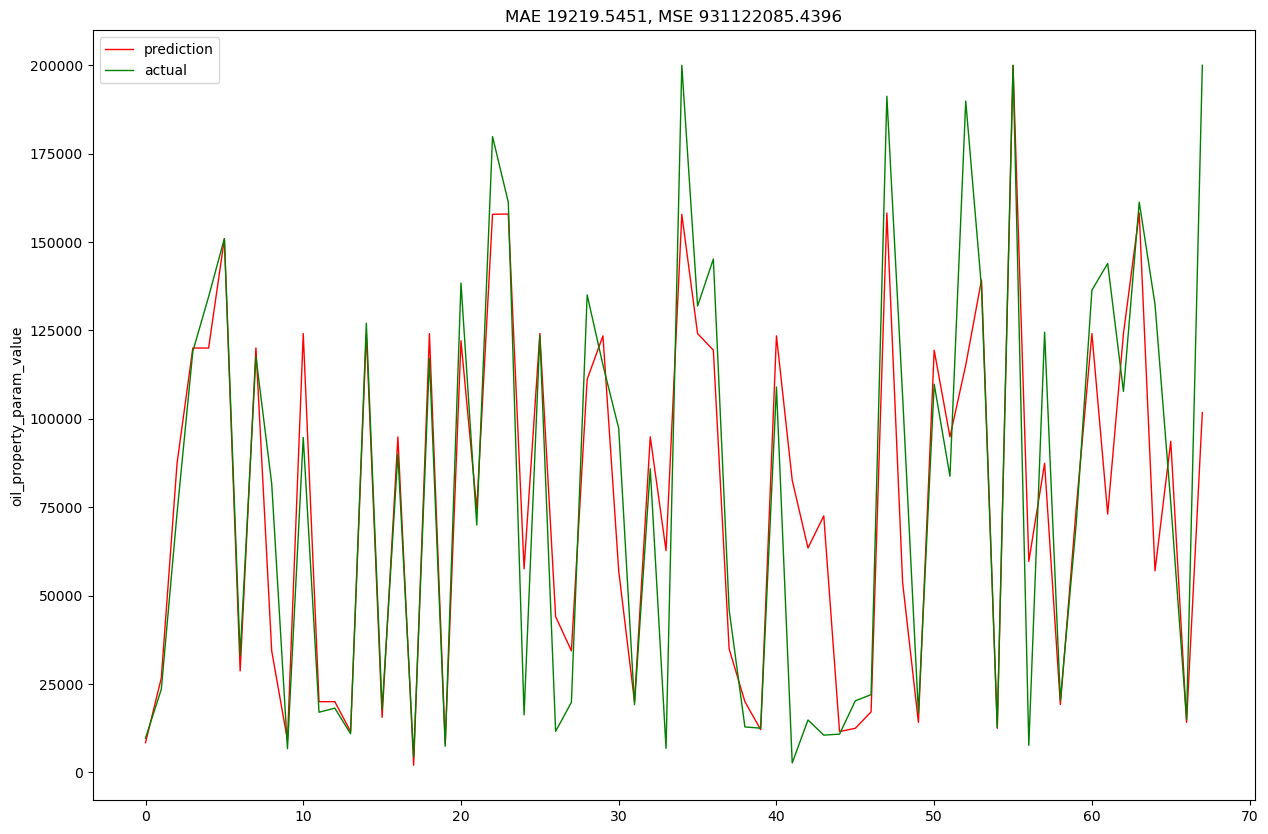

MAE score: 19219.5451
MSE score: 931122085.4396

GradientBoostingRegressor


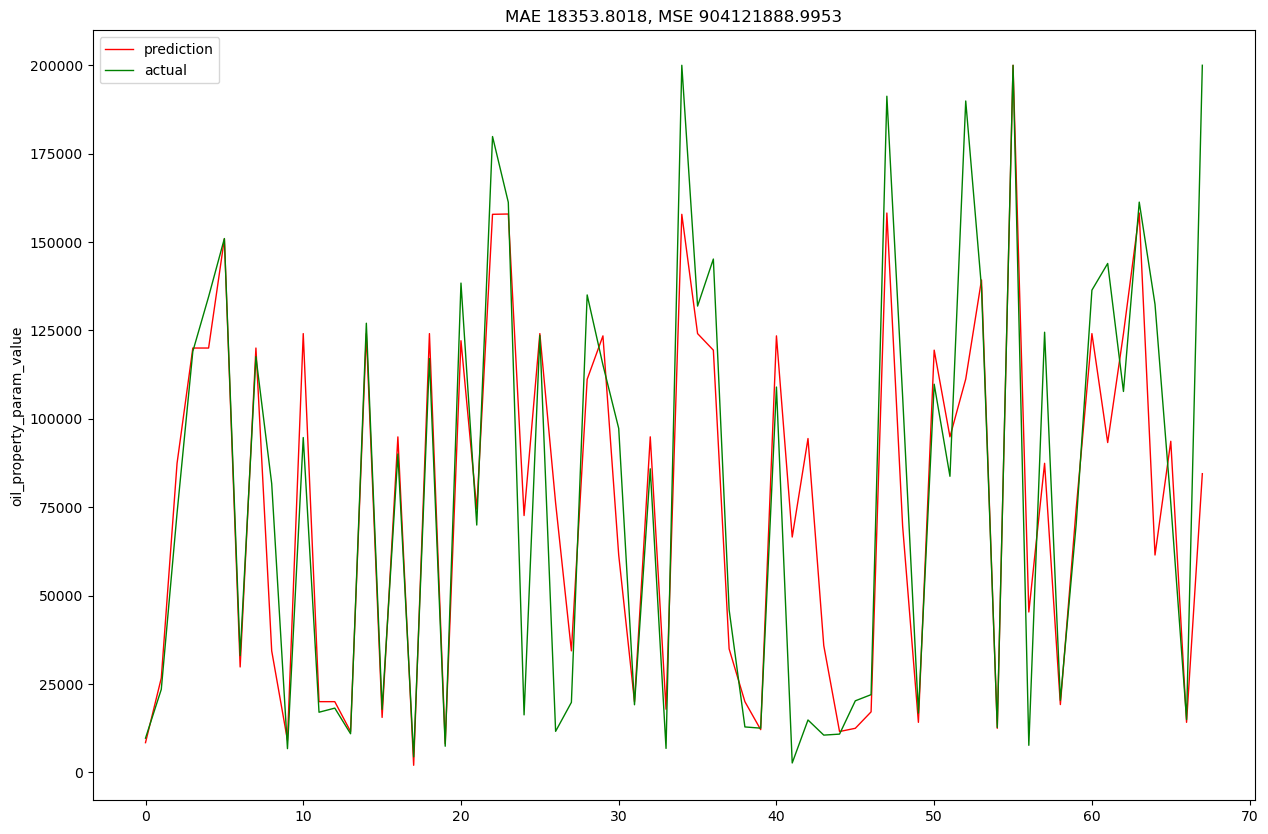

MAE score: 18353.8018
MSE score: 904121888.9953

Stack model


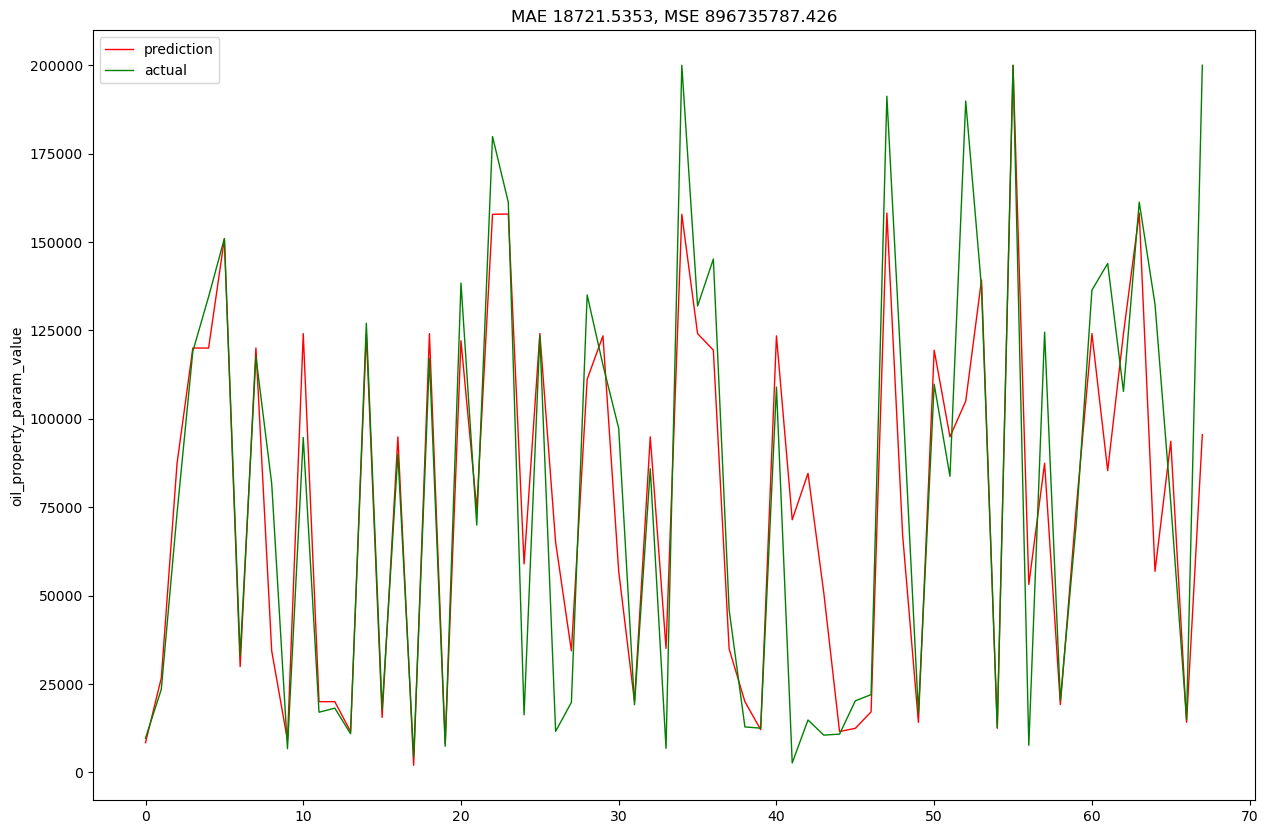

MAE score: 18721.5353
MSE score: 896735787.426


In [12]:
config = load_config("config.yml", "embeddings_sim", "SmallNN")
regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
regression_models.fit_and_evaluate()

## Pedict Regressos

In [13]:

_, _, _, _, preds = regression_models.ridge_test()

joined_df_test['predictions'] = preds
inference_regressors = joined_df_test[['blend_id', 'predictions']]

In [14]:
inference_regressors.to_csv(path_or_buf='./materials/inference_regressors.csv', index=False)

In [52]:
inference_regressors


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s


In [13]:
# from utils import SmallNN

# nn_model = SmallNN(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), config=config)
# nn_model.fit_and_evaluate()

In [12]:
# from sklearn.model_selection import train_test_split
# scaler_ = StandardScaler() # RobustScaler

# regressor = LstmRegressor(units=50, dropout_rate=0.005, optimizer='rmsprop', epochs=200, 
#                           batch_size=8, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

# X_train, X_test, y_train, y_test = train_test_split(
#             dataset.data_x.reshape(config['input']), dataset.data_y.reshape(config['input'][0]), test_size=0.2, random_state=42
#         )
# model, _ = regressor.fit(X_train, y_train, X_test, y_test)